# Discretization with Decision Trees



Discretization with decision trees consists of using a decision tree to identify the optimal bins. When a decision tree makes a decision, it assigns an observation to one of its end leaves. Therefore, any decision tree will generate a discrete output, whose values are the predictions at each of its n leaves.

How to do discretization with trees?

- 1) Train a decision tree of limited depth (2, 3  or 4) using the variable we want to discretize and the target.
- 2) Replace the values by the output returned by the tree. 


### Advantages

- The output returned by the decision tree is monotonically related to the target.
- The tree end nodes, or bins, in the discretized variable show decreased entropy, that is, the observations within each bin are more similar among themselves than to those of other bins.

### Limitations

- Prone over-fitting
- More importantly, some tuning of the tree parameters is needed to obtain the optimal number of splits (e.g., tree depth, minimum number of samples in one partition, maximum number of partitions, and a minimum information gain). This it can be time consuming.

## Demo

In [580]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

In [581]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv(
    '../../Datasets/titanic.csv',
    usecols=['age', 'fare', 'survived'])


data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [582]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

In [583]:
def impute_na(data, variable):
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [584]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

## Discretization with trees

In [585]:
# example: build Classification tree using Age to predict Survived

tree_model = DecisionTreeClassifier(max_depth=2)

tree_model.fit(X_train['age'].to_frame(), y_train) #building a tree of suvivival based on age

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [586]:
# "replace values with predictions

X_train['age_prob'] = np.round(
    tree_model.predict_proba(X_train['age'].to_frame())[:, 1], 3) #predicting the probability of survival based on age (train data)

X_test['age_prob'] = np.round(
    tree_model.predict_proba(X_test['age'].to_frame())[:, 1], 3) #predicting the probability of survival based on age (For test data)

X_train.head(10)

# for age 13 participant, the probability of survival is 0.611

,age,fare,age_prob
501,13.0,19.5000,0.611
588,4.0,23.0000,0.458
402,30.0,13.8583,0.393
1193,40.5,7.7250,0.393
686,22.0,7.7250,0.393
971,39.0,7.8792,0.393
117,30.0,56.9292,0.393
540,2.0,26.0000,0.458
294,49.0,110.8833,0.393
261,35.0,26.2875,0.393


In [587]:
# let's explore how many end points the tree created

X_train['age_prob'].unique()

# 4 unique percentage values corresponding to the 4 leaf nodes of the tree

array([0.611, 0.458, 0.393, 0.287])

Text(0, 0.5, 'Survived')

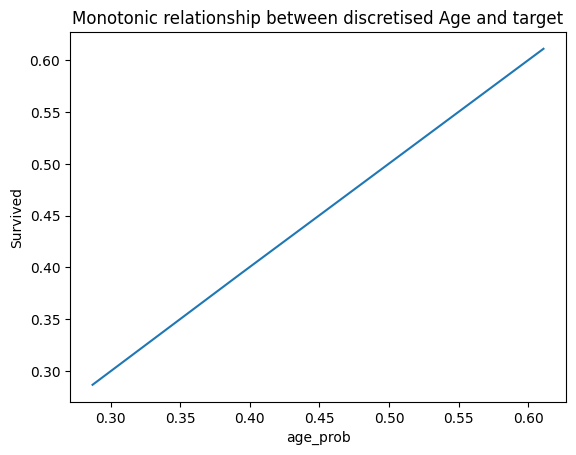

In [588]:
# relationship with target

y_train.groupby(X_train['age_prob']).mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')


#survived vs age_prob is monotonic

This graph looks monotonic as it's increasing

Text(0, 0.5, 'Survived')

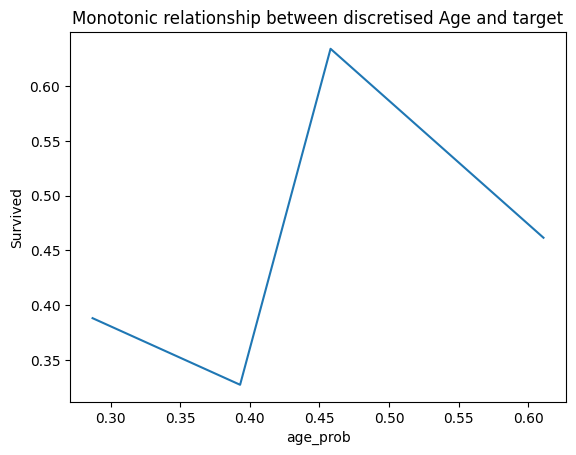

In [589]:
y_test.groupby(X_test['age_prob']).mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

We can't see a proper monotonic relationship between x_test age and y_test survival rate.

<Axes: xlabel='age_prob'>

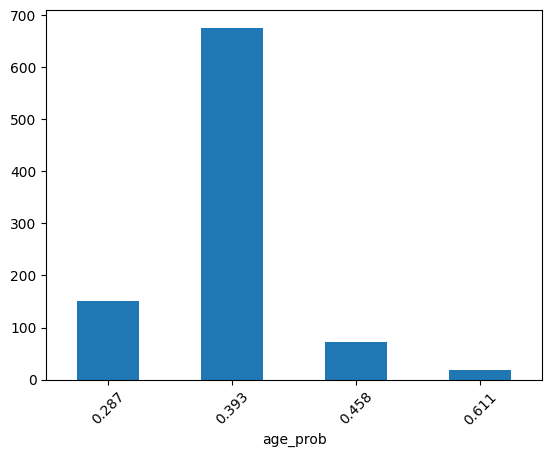

In [590]:
# number of passengers per node / bin

X_train['age_prob'].value_counts().sort_index().plot.bar(rot=45)

# most of the passengers had the probability of survival -> 39%

<Axes: xlabel='age_prob'>

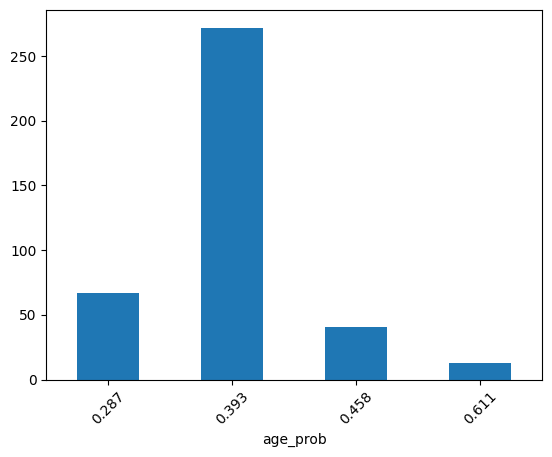

In [591]:
X_test['age_prob'].value_counts().sort_index().plot.bar(rot=45)

In [592]:
# let's see the Age limits buckets generated by the tree
# by capturing the minimum and maximum age per each probability bucket, 
# we get an idea of the bucket cut-offs

tmp = pd.concat( [X_train.groupby(['age_prob'])['age'].min(),
            X_train.groupby(['age_prob'])['age'].max()], axis=1)

tmp.columns = ["min", "max"]

tmp

# bucket 0.287 had min age 16 and max age 21 etc.

,min,max
age_prob,,
0.287,16.0000,21.0
0.393,22.0000,74.0
0.458,0.1667,11.5
0.611,12.0000,15.0


In [593]:
# get interval edges

"""bins = list(X_train.groupby(['age_prob'])['age'].min().sort_values().values)

bins"""

"bins = list(X_train.groupby(['age_prob'])['age'].min().sort_values().values)\n\nbins"

In [594]:
# expand to plus and minus inf
"""
bins[0] = -np.inf
bins.append(np.inf)

bins"""

'\nbins[0] = -np.inf\nbins.append(np.inf)\n\nbins'

## Tree visualization


Each leaf node (the bottom boxes with no children) shows a value = [n1, n2] where:

n1 = number of samples that didn't survive (class 0)
n2 = number of samples that survived (class 1)
The probability shown in your array is calculated as: 
n2 / (n1 + n2)

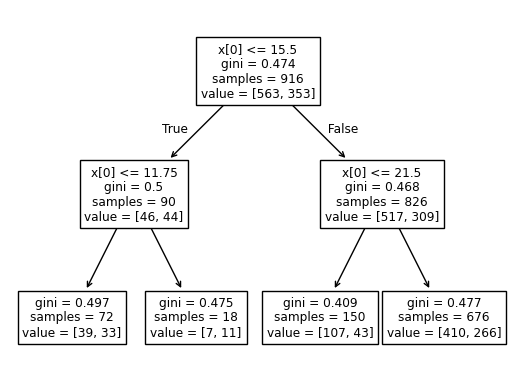

In [595]:
# alternative way of visualizing

from sklearn.tree import plot_tree

plot_tree(tree_model)
plt.show()

# we had 4 unique probability values corresponding to 4 leaf nodes. Those were 0.287, 0.393, 0.458, 0.611

# You can verify them here.

# for node 1 value is [39,33]. So, the probability of survival is 33/(39+33)=0.458

# for node 2, value is [7,11]. So, the probability of survival is 11/(7+11)=0.611

# for node 3, value is [107,43]. So, the probability of survival is 43/(107+43)=0.287

# for node 4, value is [410,266]. So, the probability of survival is 266/(410+266)=0.393

## Optimizing the decision tree

There are a number of parameters that we could optimize to obtain the best split using decision trees.

I will optimize the tree depth for this demonstration. But remember that we could also optimize the remaining parameters of the decision tree. 

Visit [sklearn website](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) to see which other parameters can be optimized.

In [596]:
from sklearn.model_selection import GridSearchCV #using grid search to find the best max_depth

In [597]:
parameters = {'max_depth':[1, 2, 3, 4]} #optimizing the depth of the tree (4 nodes)

clf = GridSearchCV(
    tree_model,
    parameters,
    cv=3,
    refit=True, # so that it returns a fitted model
)

clf.fit(X_train["age"].to_frame(), y_train)

,estimator,DecisionTreeC...r(max_depth=2)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [598]:
# the results

pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001669,0.000477,0.001334,0.000471,1,{'max_depth': 1},0.614379,0.593443,0.573770,0.593864,0.016581,3
1,0.001670,0.000474,0.001170,0.000239,2,{'max_depth': 2},0.614379,0.606557,0.590164,0.603700,0.010090,1
2,0.002332,0.000472,0.001335,0.000470,3,{'max_depth': 3},0.601307,0.590164,0.573770,0.588414,0.011310,4
3,0.001666,0.000471,0.001333,0.000472,4,{'max_depth': 4},0.611111,0.609836,0.577049,0.599332,0.015765,2


In [599]:
# the most interesting part of the resutls

pd.DataFrame(clf.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

# here we can see max depth 2 has most accuracy 60.03%

# so,the decision tree still looks like

"""Level 0 (Root):     [All data]
                        |
                   Age <= X?
                   /        \
Level 1:      [Left]      [Right]
               |              |
          Age <= Y?      Age <= Z?
          /      \        /      \
Level 2: [L1]  [L2]    [L3]    [L4]"""

<>:16: SyntaxWarning: invalid escape sequence '\ '
<>:16: SyntaxWarning: invalid escape sequence '\ '
C:\Users\shahr\AppData\Local\Temp\ipykernel_22380\3183882951.py:16: SyntaxWarning: invalid escape sequence '\ '
  /      \        /      \


'Level 0 (Root):     [All data]\n                        |\n                   Age <= X?\n                   /        Level 1:      [Left]      [Right]\n               |              |\n          Age <= Y?      Age <= Z?\n          /      \\        /      Level 2: [L1]  [L2]    [L3]    [L4]'

In [600]:
# the best depth

clf.best_params_

{'max_depth': 2}

In [601]:
# the trained decision tree

clf.best_estimator_

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [602]:
# "discretize" the variable

X_train['age_prob'] = np.round(
    clf.best_estimator_.predict_proba(X_train['age'].to_frame())[:, 1], 3)


X_test['age_prob'] = np.round(
    clf.best_estimator_.predict_proba(X_test['age'].to_frame())[:, 1], 3)

Text(0, 0.5, 'Survived')

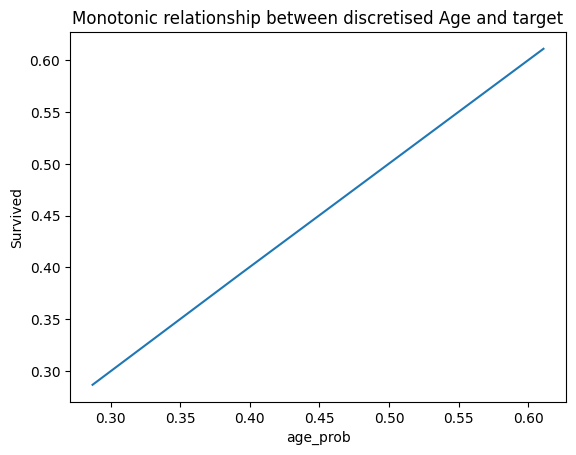

In [603]:
# relationship with target

y_train.groupby(X_train['age_prob']).mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

The trainig data yet has monotonic relation

Text(0, 0.5, 'Survived')

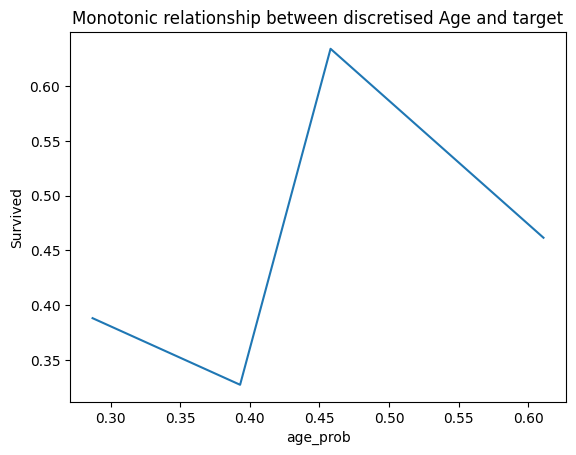

In [604]:
y_test.groupby(X_test['age_prob']).mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Still the test data has non-monotonic relation

### New approach : Original vs Improved Approach

Let's compare the original approach (max_depth=2 only) with the improved approach (max_depth + min_samples_leaf)

In [605]:
#Using max_depth=2 only (from earlier in notebook)

tree_model_original = DecisionTreeClassifier(max_depth=2)
tree_model_original.fit(X_train['age'].to_frame(), y_train)

# Create discretized features
X_train['age_prob_original'] = np.round(
    tree_model_original.predict_proba(X_train['age'].to_frame())[:, 1], 3)

X_test['age_prob_original'] = np.round(
    tree_model_original.predict_proba(X_test['age'].to_frame())[:, 1], 3)

print("Original approach - unique buckets:", X_train['age_prob_original'].unique())

Original approach - unique buckets: [0.611 0.458 0.393 0.287]


In [606]:
# Compare distributions
print("=" * 60)
print("(max_depth=2 only)")
print("=" * 60)
print("\nTrain distribution:")
print(X_train['age_prob_original'].value_counts().sort_index())
print("\nTest distribution:")
print(X_test['age_prob_original'].value_counts().sort_index())

(max_depth=2 only)

Train distribution:
age_prob_original
0.287    150
0.393    676
0.458     72
0.611     18
Name: count, dtype: int64

Test distribution:
age_prob_original
0.287     67
0.393    272
0.458     41
0.611     13
Name: count, dtype: int64


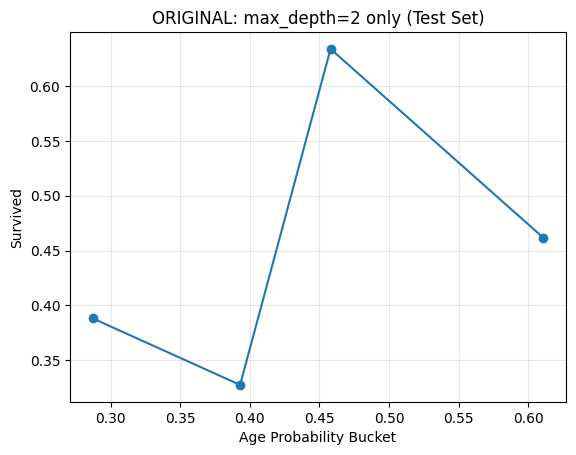

In [607]:
# ORIGINAL: Check monotonicity on test set
y_test.groupby(X_test['age_prob_original']).mean().plot(marker='o')
plt.title('ORIGINAL: max_depth=2 only (Test Set)')
plt.ylabel('Survived')
plt.xlabel('Age Probability Bucket')
plt.grid(True, alpha=0.3)
plt.show()

Still the test data has non-monotonic relation

# Optimize both max_depth AND min_samples_leaf together

In [608]:

parameters = {
    'max_depth': [1, 2, 3],
    'min_samples_leaf': [30, 50, 100]  # ensures each bucket has enough samples
}

clf_improved = GridSearchCV(
    DecisionTreeClassifier(),
    parameters,
    cv=3,
    refit=True
)

clf_improved.fit(X_train["age"].to_frame(), y_train)

,estimator,DecisionTreeClassifier()
,param_grid,"{'max_depth': [1, 2, ...], 'min_samples_leaf': [30, 50, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [609]:
# View results
pd.DataFrame(clf_improved.cv_results_)[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False)

,params,mean_test_score,std_test_score
2,"{'max_depth': 1, 'min_samples_leaf': 100}",0.614629,0.001350
5,"{'max_depth': 2, 'min_samples_leaf': 100}",0.614629,0.001350
8,"{'max_depth': 3, 'min_samples_leaf': 100}",0.614629,0.001350
3,"{'max_depth': 2, 'min_samples_leaf': 30}",0.605886,0.006153
6,"{'max_depth': 3, 'min_samples_leaf': 30}",0.599329,0.014179
0,"{'max_depth': 1, 'min_samples_leaf': 30}",0.593864,0.016581
1,"{'max_depth': 1, 'min_samples_leaf': 50}",0.593864,0.016581
4,"{'max_depth': 2, 'min_samples_leaf': 50}",0.593864,0.016581
7,"{'max_depth': 3, 'min_samples_leaf': 50}",0.587307,0.024989


In [610]:
# Best parameters
print("Best parameters:", clf_improved.best_params_)
print("Best score:", clf_improved.best_score_)

Best parameters: {'max_depth': 1, 'min_samples_leaf': 100}
Best score: 0.6146290938962106


In [611]:
# Apply the improved model to create discretized features

X_train['age_prob_improved'] = np.round(
    clf_improved.best_estimator_.predict_proba(X_train['age'].to_frame())[:, 1], 3)

X_test['age_prob_improved'] = np.round(
    clf_improved.best_estimator_.predict_proba(X_test['age'].to_frame())[:, 1], 3)

Text(0.5, 0, 'Age Probability Bucket')

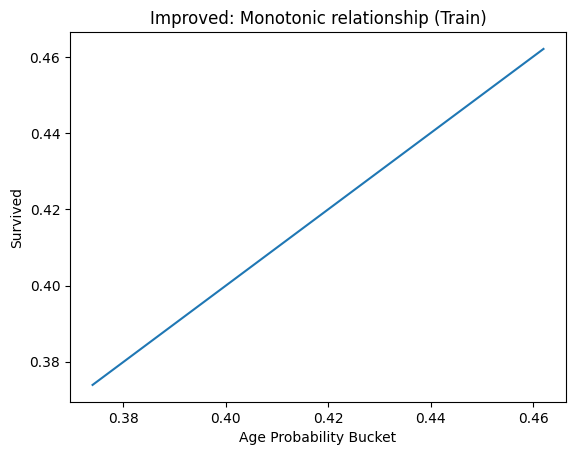

In [612]:
# Check monotonicity on TRAIN set
y_train.groupby(X_train['age_prob_improved']).mean().plot()
plt.title('Improved: Monotonic relationship (Train)')
plt.ylabel('Survived')
plt.xlabel('Age Probability Bucket')

Text(0.5, 0, 'Age Probability Bucket')

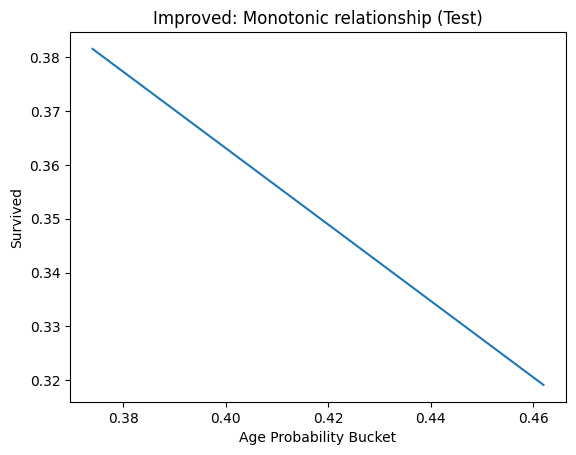

In [613]:
# Check monotonicity on TEST set (this should be improved!)
y_test.groupby(X_test['age_prob_improved']).mean().plot()
plt.title('Improved: Monotonic relationship (Test)')
plt.ylabel('Survived')
plt.xlabel('Age Probability Bucket')

The test set has non-monotic relation

In [614]:
# Check sample distribution - should be more balanced now
print("Train distribution:")
print(X_train['age_prob_improved'].value_counts().sort_index())
print("\nTest distribution:")
print(X_test['age_prob_improved'].value_counts().sort_index())

Train distribution:
age_prob_improved
0.374    797
0.462    119
Name: count, dtype: int64

Test distribution:
age_prob_improved
0.374    346
0.462     47
Name: count, dtype: int64
